In [321]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import math
from scipy import linalg as LA

### H5.1: Cross-validation
The file TrainingRidge.csv contains the training set, with 200 observations and corre-
sponding target values (ground truth/labels) {(x(α),y(α))}. The two input variables for each T
observation $ x^\alpha\ = ( x1^\alpha\ , x2^\alpha\ )^T $ appear in the first 2 columns. The target values y(α) appear in
the last column.

The data contained in the second file ValidationRidge.csv serves as the validation set.
It follows the same format as above. The validation set contains 1476 pairs {(x(β), y(β))}. The
values of $ x^\beta\ = ( x1^\beta\ , x2^\beta\ )^T $ form a 36 × 41 grid in input space.

In [322]:
# sphereing pre-processing functionality 
def PCA(x,**kwargs):
    # regularization parameter for numerical stability
    lam = 10**(-7)
    if 'lam' in kwargs:
        lam = kwargs['lam']

    # create the correlation matrix
    P = float(x.shape[1])
    Cov = 1/P*np.dot(x,x.T) + lam*np.eye(x.shape[0])

    # use numpy function to compute eigenvalues / vectors of correlation matrix
    d,V = np.linalg.eigh(Cov)
    return d,V

# ZCA spherer 
def ZCA_spherer(x,**kwargs):
    # Step 1: mean-center the data
    x_means = np.mean(x,axis = 1)[:,np.newaxis]
    x_centered = x - x_means

    # Step 2: compute pca transform on mean-centered data
    d,V = PCA(x_centered,**kwargs)

    # Step 3: divide off standard deviation of each (transformed) input, 
    # which are equal to the returned eigenvalues in 'd'.  
    stds = (d[:,np.newaxis])**(0.5)

    # check to make sure thta x_stds > small threshold, for those not
    # divide by 1 instead of original standard deviation
    ind = np.argwhere(stds < 10**(-5))
    if len(ind) > 0:
        ind = [v[0] for v in ind]
        adjust = np.zeros((stds.shape))
        adjust[ind] = 1.0
        stds += adjust

    # create normalizer / inverse-normalizer
    return np.dot(V,np.dot(V.T,x_centered)/stds)

#try with function again, does my function have to be normalized to work?

x_train: (200, 2)
x_train_centered: (200, 2)
C: (2, 2)
λ: (2, 2)
E: (2, 2)
x_train_decorrelated: (2, 200)
x_train_sphered: (2, 200)


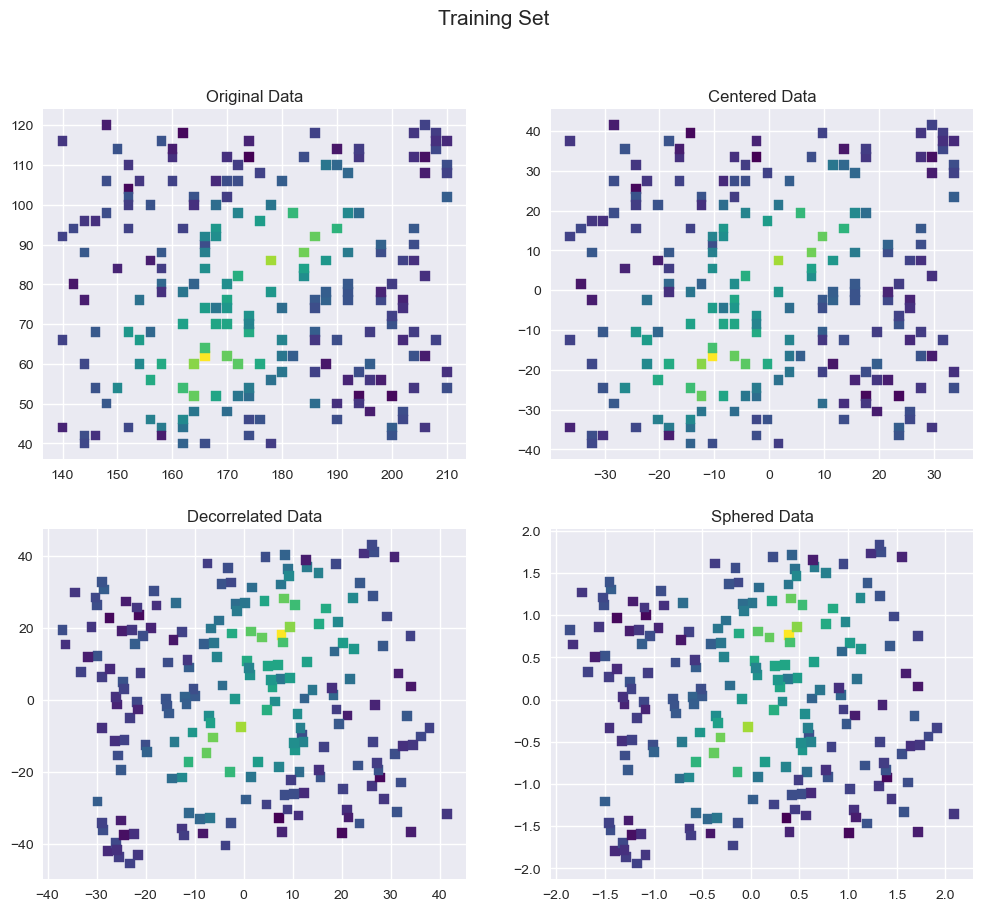

x_train_sphered mean: [0. 0.]
x_train_spheredstd: [1. 1.]


In [426]:
# Training Set 

data_train = np.genfromtxt('Data/TrainingRidge.csv', delimiter=',',dtype=float, skip_header=1)
x_train = data_train[:,0:2]
yT_train = data_train[:,2]

#Centering the data
x_train_centered = x_train - np.mean(x_train, axis=0)  

#Convolving the data
C = np.cov(x_train_centered, rowvar=False) #nxn matrix

#Computing the eigenvalues and eigenvectors

λ, E = LA.eig(C) #eigenvalues are sorted in ascending order (eigenvalues/eigenvectors are sorted by column)
#diagonal matrix of eigenvalues
λ = np.diag(1/np.sqrt(λ))
λ = λ.real.round(4)

# #Decorrelate the data
x_train_decorrelated = E.T@x_train_centered.T

print(f'x_train: {x_train.shape}')
print(f'x_train_centered: {x_train_centered.shape}')
print(f'C: {C.shape}')
print(f'λ: {λ.shape}')
print(f'E: {E.shape}')
print(f'x_train_decorrelated: {x_train_decorrelated.shape}')

# #Sphered data / Whitened data
x_train_sphered = λ@x_train_decorrelated 
x_train_sphered = np.dot(np.dot(λ, E.T), x_train_centered.T)
print(f'x_train_sphered: {x_train_sphered.shape}')

# Plot of the data
plt.style.use('seaborn')

fig = plt.figure(figsize=(12,10))
fig.suptitle('Training Set', fontsize=15)

#Original data
ax1 = fig.add_subplot(221)
ax1.scatter(x_train[:,0], x_train[:,1], c=yT_train, marker = 's' ,cmap='viridis')
ax1.title.set_text('Original Data')

#Centered data
ax2 = fig.add_subplot(222)  
ax2.scatter(x_train_centered[:,0], x_train_centered[:,1], c=yT_train, marker = 's',cmap='viridis')
ax2.title.set_text('Centered Data')

#Decorrelated data 
ax3 = fig.add_subplot(223)  
ax3.scatter(x_train_decorrelated[0,:], x_train_decorrelated[1,:], c=yT_train, marker = 's',cmap='viridis') 
ax3.title.set_text('Decorrelated Data')

#Whitened data
ax4 = fig.add_subplot(224) 
ax4.scatter(x_train_sphered[0,:], x_train_sphered[1,:], marker = 's',c=yT_train, cmap='viridis')
ax4.title.set_text('Sphered Data')

plt.show()

#properties of the data after whitening/sphering
print(f'x_train_sphered mean: {np.round(np.mean(x_train_sphered, axis=1))}')
print(f'x_train_spheredstd: {np.round(np.std(x_train_sphered, axis=1))}')


In [422]:
# Preprocessing of the validation set 

data_validate = np.genfromtxt('Data/ValidationRidge.csv', delimiter=',',dtype=float, skip_header=1)

x_validate = data_validate[:,0:2]
yT_validate = data_validate[:,2]

# Testing

x_test_center = x_validate - np.mean(x_train, axis=0) #centering the data
x_test_decorrelate = E.T@x_test_center.T #decorrelating the data
x_test_sphere = λ@x_test_decorrelate #whitening the data

print(f'x_test_center: {x_test_center.shape}')
print(f'x_test_decorrelate: {x_test_decorrelate.shape}')
print(f'x_test_sphere: {x_test_sphere.shape}')


x_test_center: (1476, 2)
x_test_decorrelate: (2, 1476)
x_test_sphere: (2, 1476)


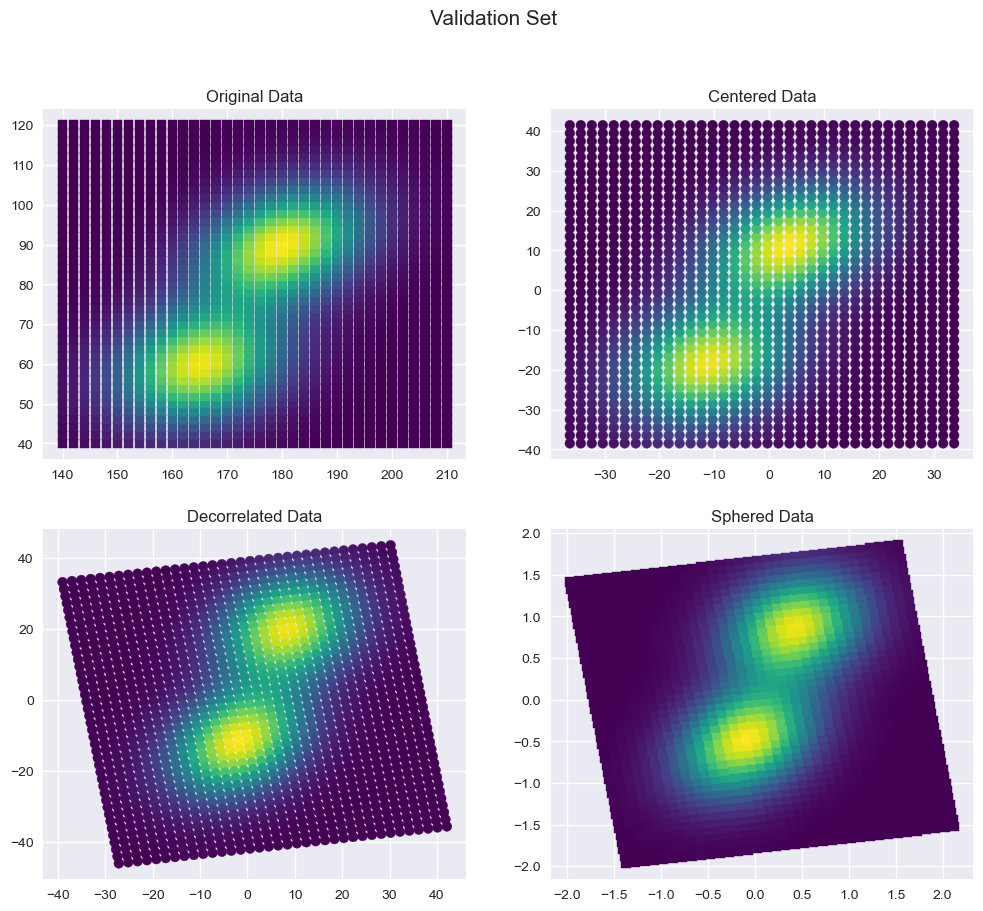

x_test_sphered mean: [ 0. -0.]
x_test_sphered std: [1. 1.]


In [427]:
# Plot of the data
plt.style.use('seaborn')

fig = plt.figure(figsize=(12,10))
fig.suptitle('Validation Set', fontsize=15)

# #Original data
ax1 = fig.add_subplot(221)
ax1.scatter(x_validate[:,0], x_validate[:,1], c=yT_validate, marker = 's' ,cmap='viridis')
ax1.title.set_text('Original Data')

#Centered data
ax2 = fig.add_subplot(222)  
ax2.scatter(x_test_center[:,0], x_test_center[:,1], c=yT_validate, cmap='viridis')
ax2.title.set_text('Centered Data')

#Decorrelated data
ax3 = fig.add_subplot(223)  
ax3.scatter(x_test_decorrelate[0,:], x_test_decorrelate[1,:], c=yT_validate, cmap='viridis') 
ax3.title.set_text('Decorrelated Data')

#Whitened data
ax4 = fig.add_subplot(224) 
ax4.scatter(x_test_sphere.T[:,0], x_test_sphere.T[:,1], marker = 's', c=yT_validate.T, cmap='viridis')
ax4.title.set_text('Sphered Data')

plt.show()

#properties of the data after whitening/sphering
print(f'x_test_sphered mean: {np.round(np.mean(x_test_sphere, axis=1))}')
print(f'x_test_sphered std: {np.round(np.std(x_test_sphere, axis=1))}')

##### Teil B
Feature Expansion: A single linear neuron is not able to predict the target labels very well. To increase the representational power of the model class, expand the sphered 2D input to all possible monomials up to degree 9.
Here, a monomial of order k corresponds to a term x1^lx2^m with l + m = k.
The model should contain all 55 terms x1^lx2^m with l + m = k for k = 0, 1, ..., 9. These
monomials can be enumerated by i = 1, . . . , d = 55 defining φi(x). The prediction function
which feeds into the quadratic cost measure ET is given by


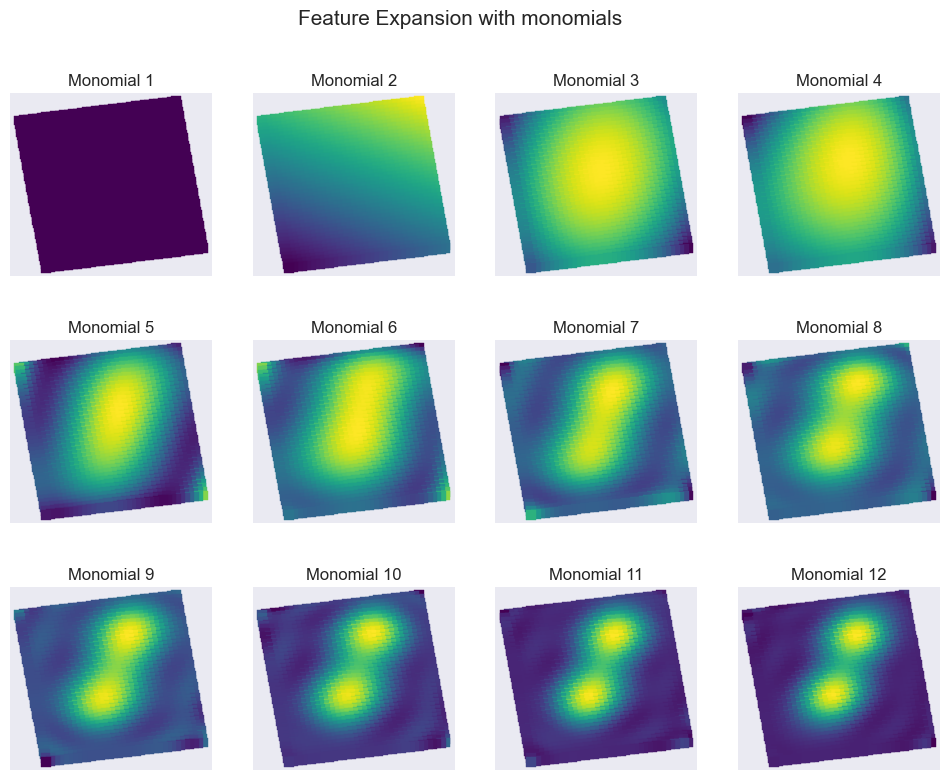

In [458]:
# demonstrate the types of features created
from sklearn.preprocessing import PolynomialFeatures

#Using the validation set to test the monomial expansion for feature expansion

fig = plt.figure(figsize=(12,12))
fig.suptitle('Feature Expansion with monomials', fontsize=15, y=0.95)
y_regression = []

for i in range(12):
    #Performing the polynomial transformation with monomials
    poly = PolynomialFeatures(degree=i)
    x_poly = poly.fit_transform(x_test_sphere.T).T #transposing the data to get the correct shape
    # print(f'x_poly {i}: {x_poly.shape}')
    
    phi = x_poly
    
    w = np.linalg.inv(phi @ phi.T)@ phi @ yT_validate.T
    # w = w.reshape(-1,1)
    y_predicted = w.T @ phi
    y_regression.append(np.array(y_predicted))
    
    ax = fig.add_subplot(4,4,i+1)
    
    #Plotting the data
    
    # #Normal data
    # ax.scatter(x_validate[:,0], x_validate[:,1], c=y_predicted, cmap='viridis')
    
    # Sphered data 
    ax.scatter(x_test_sphere[0,:], x_test_sphere[1,:], c=y_predicted, cmap='viridis', marker = 's')
    
    #remove the ticks
    ax.set_xticks([])
    ax.set_yticks([])
    
    ax.title.set_text(f'Monomial {i+1}')
plt.subplots_adjust(hspace=0.35)

#frage: eigenvalues =0, weil die daten nicht zentriert sind? -> ja, aber dann ist die matrix nicht invertierbar
#problem with the diagonal matrix **-1/2 -> not invertible

In [451]:
for i in range(10):
    #Performing the polynomial transformation with monomials
    poly = PolynomialFeatures(degree=i)
    x_poly = poly.fit_transform(x_test_sphere.T).T 
    print(f'x_poly {i}: {x_poly.shape}')
    # print(np.linalg.inv(x_poly@x_poly.T))


x_poly 0: (1, 1476)
x_poly 1: (3, 1476)
x_poly 2: (6, 1476)
x_poly 3: (10, 1476)
x_poly 4: (15, 1476)
x_poly 5: (21, 1476)
x_poly 6: (28, 1476)
x_poly 7: (36, 1476)
x_poly 8: (45, 1476)
x_poly 9: (55, 1476)


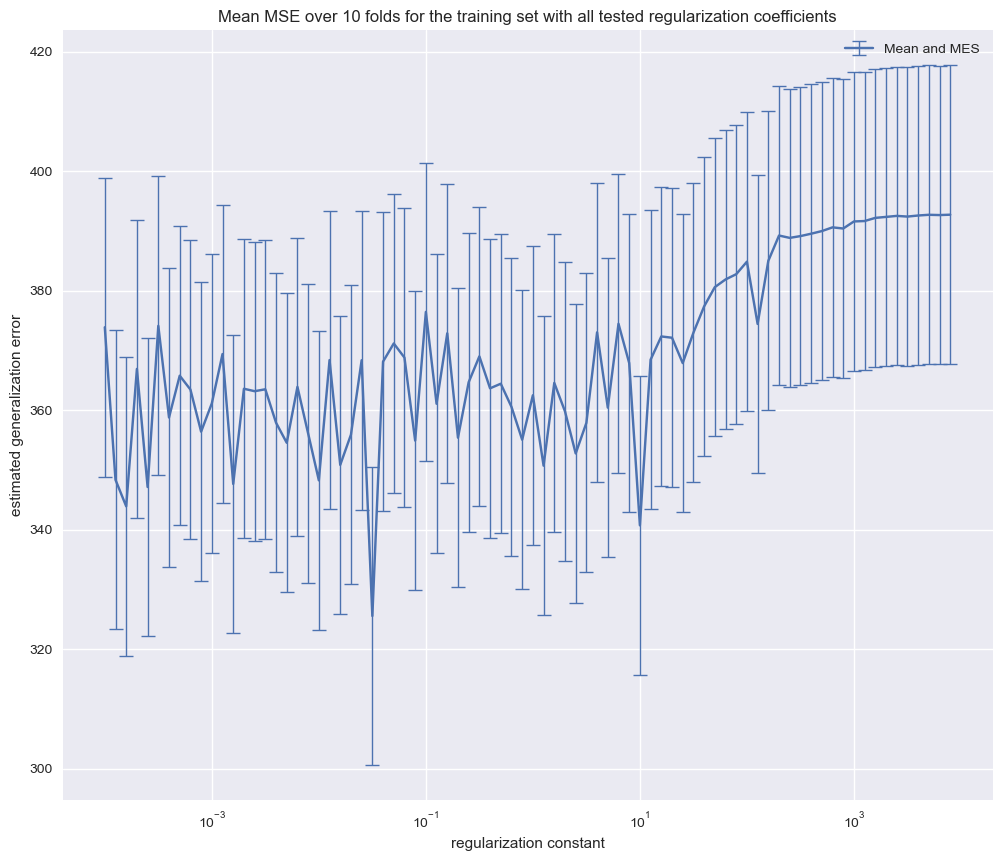

In [460]:
#cross  validation
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error


#create matrix  from -4 to 4 with step 0.1 for regularization coefficient
x = np.arange(-4, 4, 0.1)
r_coefficient = np.array([10**i for i in x])


# Training Set 

data_train = np.genfromtxt('Data/TrainingRidge.csv', delimiter=',',dtype=float, skip_header=1)
x_train = data_train[:,0:2]
yT = data_train[:,2]


#cross validation
kf = KFold(n_splits=10, shuffle=True)

#performing the cross validation
MSE = []
MEAN = []
for r in r_coefficient:
    MSE_r = []
    for train_index, test_index in kf.split(x_train):
        # print("TRAIN:", train_index, "TEST:", test_index)
        x_train_cv, x_test_cv = x_train[train_index], x_train[test_index]
        y_train_cv, y_test_cv = yT[train_index], yT[test_index]
        
        #Centering the data 
        x_centered = x_test_cv - np.mean(x_train_cv, axis=0)
        C = np.cov(x_centered, rowvar=False)
        
        #Computing the eigenvalues and eigenvectors

        λ, E = LA.eig(C) #eigenvalues are sorted in ascending order (eigenvalues/eigenvectors are sorted by column)
        #diagonal matrix of eigenvalues
        λ = np.diag(1/np.sqrt(λ))
        λ = λ.real.round(4)
        
        # #Decorrelate the data
        x_decorrelated = E.T@x_centered.T
        
        # #Sphered data / Whitened data
        x_sphered = λ@x_decorrelated 
        x_sphered = np.dot(np.dot(λ, E.T), x_centered.T)
        
        phi = x_sphered
        
        w = np.linalg.inv(phi @ phi.T + r*np.identity(phi.shape[0]))@ phi @ y_test_cv.T
        y_predicted = w.T @ phi
        
        MSE_r.append(mean_squared_error(y_test_cv, y_predicted))  
    MSE.append(MSE_r) 
    MEAN.append(np.mean(MSE_r))  
MSE = np.array(MSE) 
MEAN = np.array(MEAN)

# print(r_coefficient[np.argmin(MEAN)])
# print(f'r_coefficient: {r_coefficient.shape}')
# print(f'MSE: {MSE.shape}')
# print(f'MEAN: {MEAN.shape}')
#plot the MSE
plt.style.use('seaborn')
fig = plt.figure(figsize=(12,10))   
ax = fig.add_subplot(111)
ax.title.set_text('Mean MSE over 10 folds for the training set with all tested regularization coefficients')
# for i in range(MSE.shape[1]):
#     ax.errorbar(r_coefficient,MEAN)
# # ax.errorbar(r_coefficient, MSE)

ax.errorbar(r_coefficient, MEAN, yerr=np.argmin(MEAN), label='Mean and MES', capsize=5, capthick=1, elinewidth=1) 
ax.set_xscale('log')
ax.set_xlabel('regularization constant')
ax.set_ylabel('estimated generalization error')
ax.legend()

### Doubt: is the data normalized? if not --> where and how should I normalize it?
# keep record of the MSE for each regularization coefficient and know how to plot it for the target function and also the predicted function (for the training set and the validation set)
# where is the intersection between the sets? with all the parameters of the predicted function of the training set 
# applied to the validation set - covariance matrix, eigenvalues, eigenvectors, whitening, sphering, decorrelation, centering, mean value, etc.......
# what is the error that goes in yerr for the errorbar plot?
